#  Introduction to Atomistic Simulations with Pyiron

Before the excercise, you should:

* Be familiar with python especially with numerical libraries like numpy and plotting tools like matplotlib
* Understand how Jupyter Notebooks work

The aim of this exercise is to make you familiar with:

* A general overview of what pyiron can do
* How to set up atomic structures and run atomistic simulation codes through pyiron

## Jupyter Crash Course

1. Select cells by clicking on them.
2. Navigate through with `up` and `down` keys (or `k` and `j` for you vimmers).
3. Press Enter to edit a cell.
4. Press Shift-Enter to execute it.
5. Create new cells above or below the current one with `a` or `b`.
6. Copy, cut and paste them with `c`, `x` and `v`.
7. Press `m` to turn a cell into a markdown cell.
8. See the `Help` in the toolbar for more.

## For Today

### Importing necessary libraries

As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [2]:
from pyiron import Project

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

### Creation of a project instance

In [3]:
pr = Project("first_steps")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [4]:
pr.path

'/cmmc/u/pmathews/PyIron_data/projects/first_steps/'

In [5]:
pr

{'groups': [], 'nodes': []}

The `groups` and `nodes` will be populated later, as we add jobs and sub project to it.

### Creating atomic structures

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Creating a bulk fcc cubic unitcell

In [6]:
Al_unitcell_cubic = pr.create.structure.bulk('Al', cubic=True, a=4.04)
Al_unitcell_cubic

Al: [0. 0. 0.]
Al: [0.   2.02 2.02]
Al: [2.02 0.   2.02]
Al: [2.02 2.02 0.  ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.04, 4.04, 4.04])

Creating a super cell.

In [7]:
Al_supercell_3_3_3 = Al_unitcell_cubic.repeat([3, 3, 3])
Al_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

### Running an atomistic calculation using interatomic potentials (with LAMMPS)

Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [8]:
# Create a job
job_lammps = pr.create.job.Lammps(job_name="lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Al supercell structure we created earlier

In [9]:
# Assign an atomic structure to the job
job_lammps.structure = Al_supercell_3_3_3

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Al can be found below.  This list originates from the NIST Interatomic Potential Database.

In [10]:
# See available potentials
job_lammps.list_potentials()[20:30]

['2008--Mendelev-M-I--Al--LAMMPS--ipr1',
 '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1',
 '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-2--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-3--LAMMPS--ipr1',
 '2010--Winey-J-M--Al--LAMMPS--ipr1']

In [11]:
# Choose one of these potentials
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [12]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [13]:
job_lammps.run()

The job lammps_job was saved and received the ID: 20879319


When printing the project, the saved job will also appear under `nodes` now.

In [14]:
pr

{'groups': [], 'nodes': ['lammps_job']}

You can get a quick overview with the `job_table` method.

In [15]:
pr.job_table()

id    status chemicalformula         job       subjob projectpath  \
0  20879319  finished           Al108  lammps_job  /lammps_job    /cmmc/u/   

                                      project                  timestart  \
0  pmathews/PyIron_data/projects/first_steps/ 2023-09-21 21:52:38.883441   

                    timestop  totalcputime            computer hamilton  \
0 2023-09-21 21:52:44.425237           5.0  pmathews@cmti001#1   Lammps   

  hamversion parentid masterid  
0        0.1     None     None

### Analysing a calculation

In [16]:
pr

{'groups': [], 'nodes': ['lammps_job']}

Indexing into a `Project` loads a job from storage.

In [17]:
job_loaded = pr['lammps_job']

Jobs in turn also have groups and nodes in them, corresponding to the input and output that was stored for them.

In [18]:
job_loaded

{'groups': ['executable', 'input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'job_id', 'server', 'status']}

You will generally find all relevant data in the `output` group, for your further processing.

In [19]:
job_loaded["output"]

{'groups': ['generic', 'structure'], 'nodes': []}

The group `structure` holds the final structure at the end of the simulation, whereas the `generic` group keeps output you can expect for all atomistic jobs in pyiron.

In [20]:
job_loaded["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'natoms', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

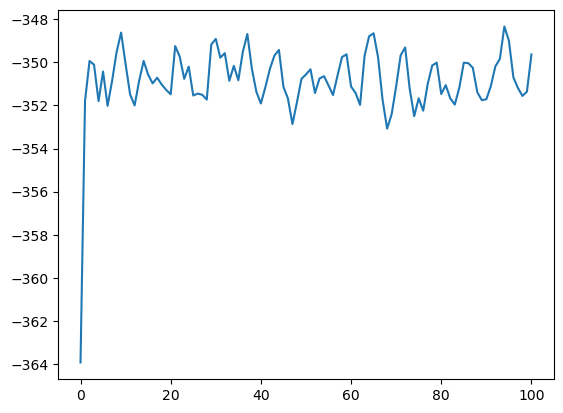

In [21]:
plt.plot(job_loaded["output/generic/energy_pot"])

Structures from the MD trajectory can be accessed using `get_structure`, passing as the argument the index of the step you want to retrieve.

In [22]:
final_struct = job_loaded.get_structure(frame=5)
final_struct.plot3d()

NGLWidget()

Using the `plot3d` method you can visualize the structure interactively.  To see the full trajectory, you can use the `animate_structure` method.

In [23]:
job_loaded.animate_structure()

/tmp/ipykernel_24078/2585133094.py:1: DeprecationWarning: pyiron_atomistics.atomistics.job.atomistic.animate_structure is deprecated: Call animate_structures() instead.  Arguments stride/center_of_mass/atom_indices/snapshot_indices/repeat can be emulated by calling trajectory() first..
  job_loaded.animate_structure()


NGLWidget(max_frame=100)

Let's go through a few more examples of visualizing the output of the job.

When you run the job, you can specify how often pyiron and lammps should be writing the intermediate structures and energies, etc. The default for this is every 100 steps.  The output group `generic/steps` contains an array to which actual step of the MD trajectory a snapshot belongs.

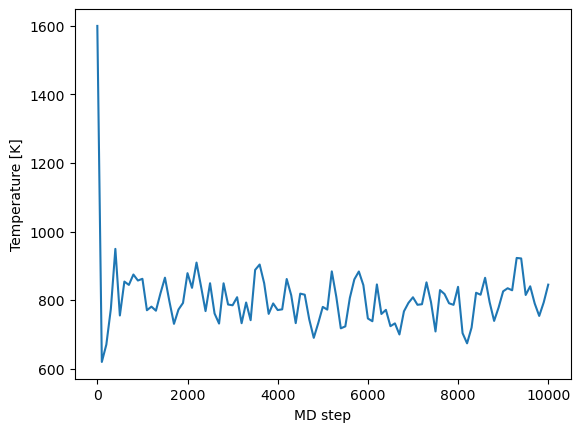

In [24]:
temperatures = job_loaded['output/generic/temperature']
steps = job_loaded['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

## More Structure Creation Tools

Creating a bulk fcc primitive unitcell and supercell.

In [25]:
Al_unitcell_primitive = pr.create.structure.bulk('Al', a=4.04)
Al_unitcell_primitive.repeat([3, 3, 3]).plot3d(particle_size=2)

NGLWidget()

Creating a vacancy is easy, just delete an atom.

In [26]:
Al_vacancy = Al_supercell_3_3_3.copy()
del Al_vacancy[0] # Deleting the first atom
print(Al_supercell_3_3_3.get_chemical_formula(), Al_vacancy.get_chemical_formula())
Al_vacancy.plot3d(particle_size=2)

Al108 Al107


NGLWidget()

Surfaces are also easy to create, thanks to ASE integration.

In [27]:
num_layers = 4
Al_fcc_111 = pr.create.structure.surface("Al", surface_type="fcc111", size=(4,4,num_layers), vacuum=12, orthogonal=True)
Al_fcc_111.plot3d(particle_size=2)

NGLWidget()

We also have some specialized methods for compounds.

In [28]:
pr.create.structure.compound.B2("Li", "Al").repeat(2).plot3d()

NGLWidget()

If needed you can also have full control over the structure.  Here we'll use it to setup a single atom and a dimer.

In [29]:
cell = np.eye(3) * 10
Al_atom_box = pr.create.structure.atoms("Al", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Al_atom_box.plot3d(particle_size=2)

NGLWidget()

In [30]:
cell = np.eye(3) * 10
Al_atom_1 = pr.create.structure.atoms("Al", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Al_atom_2 = Al_atom_1.copy()

dimer_length = 2.5
Al_atom_2.positions[:, 2] += dimer_length
Al_dimer = Al_atom_1 + Al_atom_2
Al_dimer.center()
Al_dimer.plot3d()

NGLWidget()

This demonstrates also how to build more complex structures, just `+` them together, if they have the same boundary conditions.

### Energy volume curve for Al

First we create some functions to extract the final energy and volume of a job

In [31]:
def get_volume(job):
    return job["output/generic/volume"][-1]

In [32]:
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

In [33]:
job_loaded = pr['lammps_job']

In [34]:
get_energy(job_loaded), get_volume(job_loaded)

(-337.952569550017, 1872.23847258777)

We create first a few jobs with different lattice parameters.

Project can be nested within each other with `create_group`.

In [35]:
pr_ev = pr.create_group("E_V_curve") # Creating a new sub-project within the main project
a_list = np.linspace(3.8, 4.4, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Lammps(job_name)
    job.structure = pr_ev.create.structure.bulk("Al", a=a)
    job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
    job.calc_minimize()
    job.run()

The job job_a_3_8 was saved and received the ID: 20879320
The job job_a_3_9 was saved and received the ID: 20879321
The job job_a_4_0 was saved and received the ID: 20879322
The job job_a_4_1 was saved and received the ID: 20879323
The job job_a_4_2 was saved and received the ID: 20879324
The job job_a_4_3 was saved and received the ID: 20879325
The job job_a_4_4 was saved and received the ID: 20879326


In [36]:
pr

{'groups': ['E_V_curve'], 'nodes': ['lammps_job']}

In [37]:
pr_ev.job_table()

id    status chemicalformula        job      subjob projectpath  \
0  20879320  finished              Al  job_a_3_8  /job_a_3_8    /cmmc/u/   
1  20879321  finished              Al  job_a_3_9  /job_a_3_9    /cmmc/u/   
2  20879322  finished              Al  job_a_4_0  /job_a_4_0    /cmmc/u/   
4  20879323  finished              Al  job_a_4_1  /job_a_4_1    /cmmc/u/   
3  20879324  finished              Al  job_a_4_2  /job_a_4_2    /cmmc/u/   
6  20879325  finished              Al  job_a_4_3  /job_a_4_3    /cmmc/u/   
5  20879326  finished              Al  job_a_4_4  /job_a_4_4    /cmmc/u/   

                                                project  \
0  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
1  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
2  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
4  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
3  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
6  pmathews/PyIron_data/projects/first_steps/E_V_curve/   
5  pmathews/PyIron_data/projects/first_steps/E_V_curve/   

                   timestart                   timestop  totalcputime  \
0 2023-09-21 21:52:52.198560 2023-09-21 21:52:53.458228           1.0   
1 2023-09-21 21:52:53.727575 2023-09-21 21:52:55.026706           1.0   
2 2023-09-21 21:52:55.264625 2023-09-21 21:52:56.487249           1.0   
4 2023-09-21 21:52:56.729323 2023-09-21 21:52:57.938661           1.0   
3 2023-09-21 21:52:58.206339 2023-09-21 21:52:59.425233           1.0   
6 2023-09-21 21:52:59.706199 2023-09-21 21:53:00.922937           1.0   
5 2023-09-21 21:53:01.177931 2023-09-21 21:53:02.400188           1.0   

             computer hamilton hamversion parentid masterid  
0  pmathews@cmti001#1   Lammps        0.1     None     None  
1  pmathews@cmti001#1   Lammps        0.1     None     None  
2  pmathews@cmti001#1   Lammps        0.1     None     None  
4  pmathews@cmti001#1   Lammps        0.1     None     None  
3  pmathews@cmti001#1   Lammps        0.1     None     None  
6  pmathews@cmti001#1   Lammps        0.1     None     None  
5  pmathews@cmti001#1   Lammps        0.1     None     None

Now that we have all the jobs and they finished correctly, we can analyze them.

  0%|          | 0/7 [00:00<?, ?it/s]

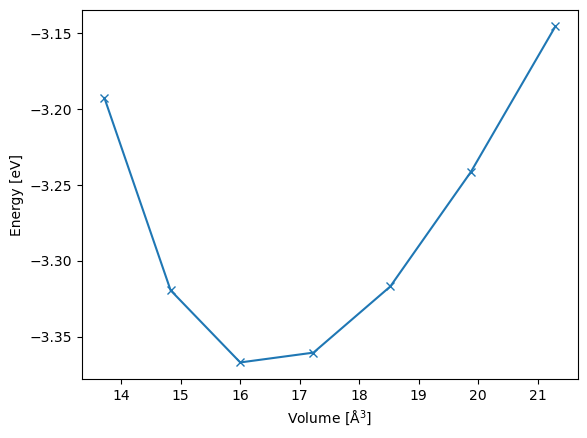

In [38]:
vol_list = []
energy_list = []

for job in pr["E_V_curve"].iter_jobs(status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

### E-V curves for DFT

We now do the same with a DFT job to allow us to compare.  Notice that the structure of the code is almost the same between DFT and Lammps, just the input parameters are different.

In [39]:
pr_ev = pr.create_group("E_V_curve_DFT") # Creating a new sub-project within the main project
a_list = np.linspace(3.8, 4.4, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Sphinx(job_name)
    job.structure = pr_ev.create.structure.bulk("Al", a=a)
    job.set_exchange_correlation_functional("PBE")
    job.plane_wave_cutoff = 350
    job.set_kpoints(mesh=[4, 4, 4])
    job.set_occupancy_smearing("fermi", 0.1)
    job.calc_minimize()
    job.run()

The job job_a_3_8 was saved and received the ID: 20879327
The job job_a_3_9 was saved and received the ID: 20879328
The job job_a_4_0 was saved and received the ID: 20879329
The job job_a_4_1 was saved and received the ID: 20879330
The job job_a_4_2 was saved and received the ID: 20879331
The job job_a_4_3 was saved and received the ID: 20879332
The job job_a_4_4 was saved and received the ID: 20879333


Also for the analysis the code necessary is the same, allowing us to easily loop over both groups and plot them together.

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

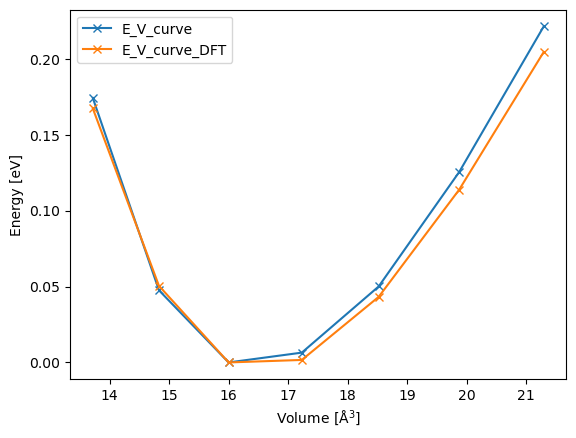

In [40]:
for group in pr.iter_groups():
    vol_list = list()
    energy_list = list()
    for job in group.iter_jobs(status="finished"):
        vol_list.append(get_volume(job))
        energy_list.append(get_energy(job))
    args = np.argsort(vol_list)
    vol_list = np.array(vol_list)
    energy_list = np.array(energy_list)
    plt.plot(vol_list[args], energy_list[args] - np.min(energy_list), "-x", label=group.name)
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]")
plt.legend();

## Additional Reading

Previous workshop materials:
- [Phasediagram Workshop 2020](https://pyiron.org/phasediagram-workshop-2020/Introduction.html)
- [Potentials Workshop 2021](https://pyiron.org/potentials-workshop-2021/README.html)
- [CECAM Workshop 2021](http://pyiron.org/swimm-workshop-2021/README.html)
- [Potentials Workshop 2022](https://pyiron.org/potentials-workshop-2022/intro.html)
- [Youtube](https://www.youtube.com/@pyironIDE)

Software from us:
- [pyiron github](https://github.com/pyiron) 
- [eisenforschung github](https://github.com/eisenforschung)
- [pyiron for experimental data](https://github.com/pyiron/pyiron_experimental)
- [pyiron for continuum simulations](https://github.com/pyiron/pyiron_continuum)
- [Automatic Melting Point Calculations](https://github.com/pyiron/pyiron_meltingpoint)
- [pyiron for machine learning potentials](https://github.com/eisenforschung/magnesium-mtp-training-data)

## For Take-Away

### Realistic Application: Melting temperature of Al

With the recipe we have, we can now go ahead and calculate the melting temperature of Al. This will actually give our first point on the phase diagram. First, the steps needed to find the melting temperature:

- Since the $T_m$ is 933 K, we can choose the range of 800-1100 K to calculate free energy
- Calculate free energy of FCC structure in this range
- Calculate free energy of liquid in this range.

By now, we have seen how to calculate the free energy of the FCC structure. This can be done rather quickly.

#### Free energy of solid

In [5]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.1362).repeat(4)

In [9]:
al_fcc = pr.create.job.Calphy("Al_fcc_tm", delete_aborted_job=True)
al_fcc.structure = structure
al_fcc.potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'
al_fcc.server.cores = 2
al_fcc.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_fcc.run()

The job Al_fcc_tm was saved and received the ID: 20843892


#### Free energy of liquid

Calculation of the free energy of liquid is as easy as changing the option `reference_phase` to `"liquid"`. That is all the change that is needed. Run the calculation..

In [11]:
al_lqd = pr.create.job.Calphy("Al_lqd_tm", delete_aborted_job=True)
al_lqd.structure = structure
al_lqd.potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'
al_lqd.server.cores = 2
al_lqd.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="liquid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_lqd.run()

The job Al_lqd_tm was saved and received the ID: 20843897


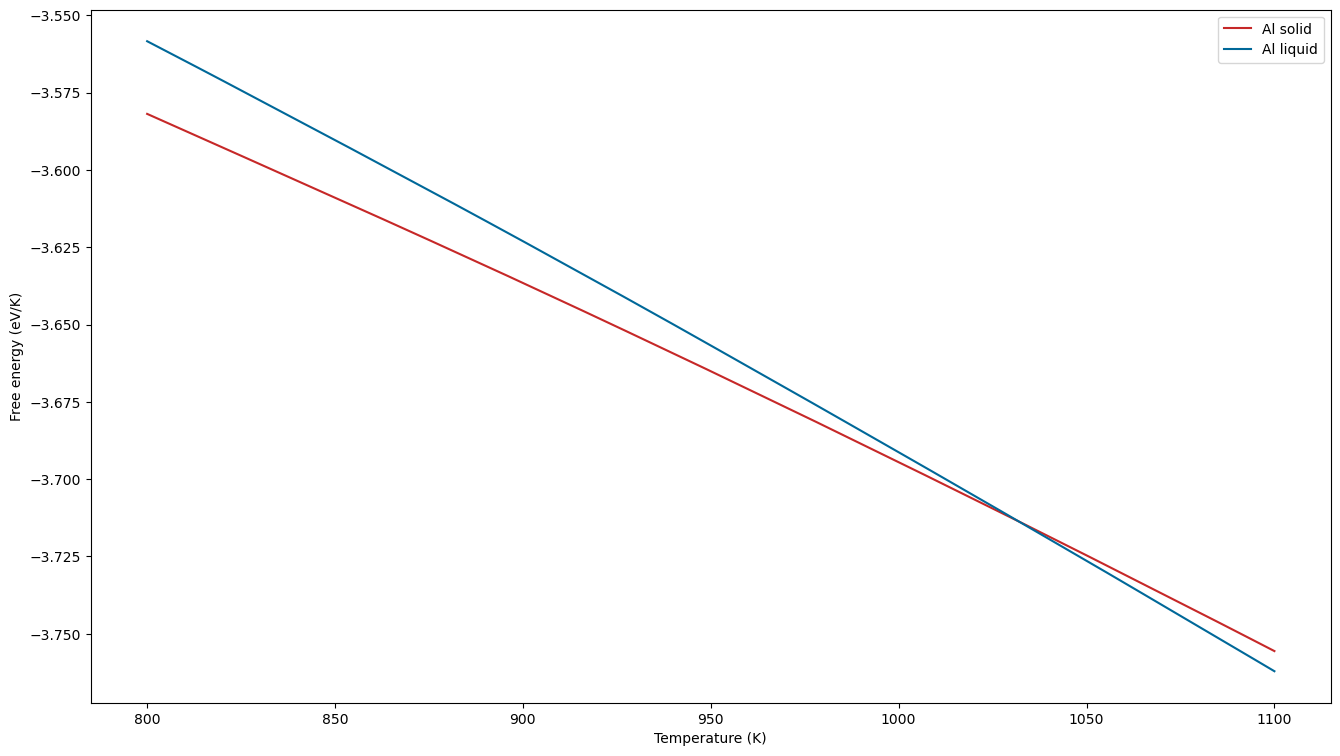

In [12]:
plt.plot(al_fcc.output.temperature, al_fcc.output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(al_lqd.output.temperature, al_lqd.output.energy_free,
        label="Al liquid", color='#006899')
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

The melting temperature is defined as the temperature at which the free energy difference between the solid and liquid phases is zero. We can also plot the free energy difference directly.

In [13]:
fediff = al_fcc.output.energy_free - al_lqd.output.energy_free

Find where the value is zero and get the corresponding temperature

In [14]:
arg = np.argsort(np.abs(fediff))[0]
tm = al_fcc.output.temperature[arg]
tm

1032.1124823203938

The calculated melting temperature is shown above.

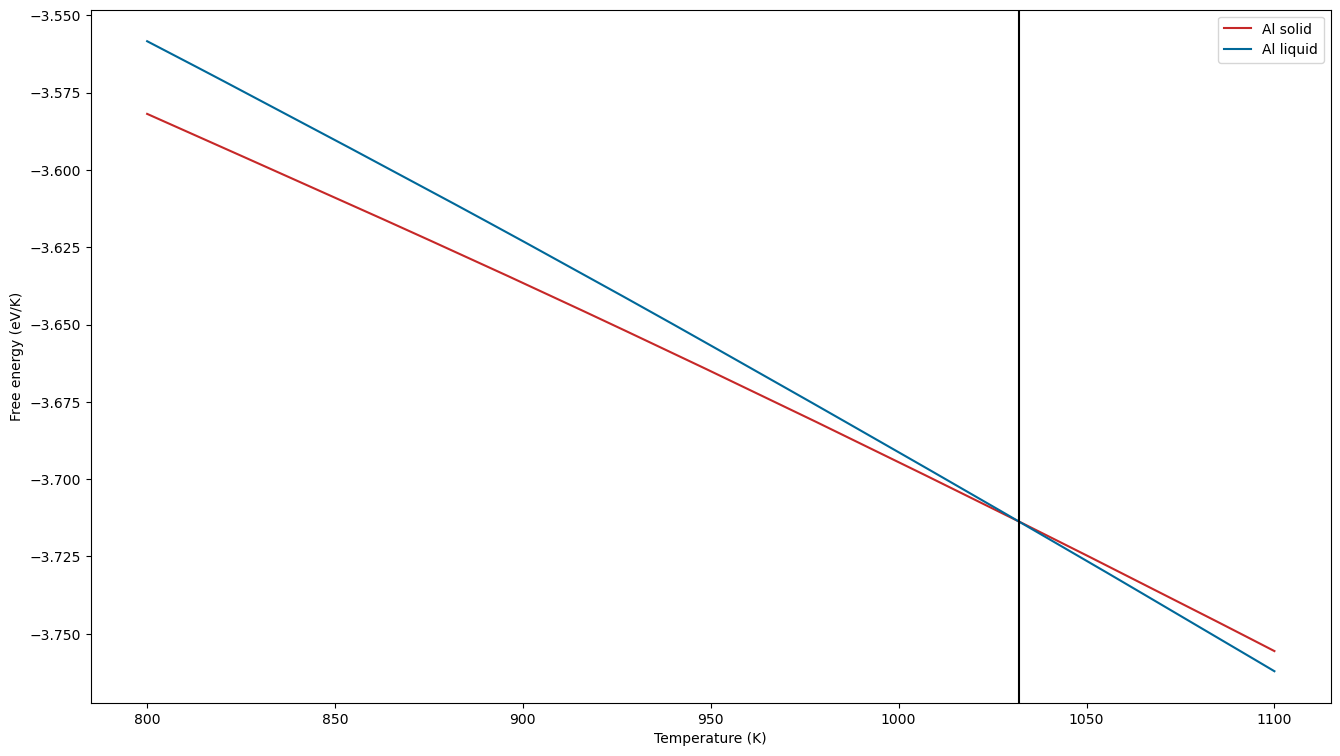

In [15]:
plt.plot(al_fcc.output.temperature, al_fcc.output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(al_lqd.output.temperature, al_lqd.output.energy_free,
        label="Al liquid", color='#006899')
plt.axvline(tm, color="black")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

### Advanced pyiron: Automated workflows and analysis tools

While we could in principle obtain thee E-V cureves by setting up and analyzing the calculations manually as done above, we could also use predefined workflows in pyiron which does this automatically

In [49]:
num_pot = 3
pot_finder = pr.inspect_emperical_potentials()
pot_list = pot_finder.find("Al").Name.to_list()[20:20+num_pot]
pot_list

['2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2']

In [50]:
def clean_project_name(name):
    return name.replace('-', '_')

In [51]:
# Automated Murnaghan using pyiron tables

pr_murn = Project("murn_auto") 

for pot in pot_list:
    
    lammps_job = pr_murn.create.job.Lammps("lammps_ref")
    lammps_job.structure = pr.create.structure.bulk("Al")
    lammps_job.potential = pot
    lammps_job.calc_minimize()
    
    # Creating a Murnaghan workflow (char names not to exceed 50 chars)
    job_name = f"murn_ref_{clean_project_name(pot)}"[:40]
    
    # The job type 'Murnaghan' sets up the appropriate workflow 
    murn_job = lammps_job.create_job(pr.job_type.Murnaghan, job_name)
    murn_job.input["num_points"] = 9
    murn_job.run()

2023-03-26 07:46:30,944 - pyiron_log - WARNING - The job murn_ref_2009__Mendelev_M_I__Al_Mg__LAMM is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-03-26 07:46:31,097 - pyiron_log - WARNING - The job murn_ref_2009__Purja_Pun_G_P__Ni_Al__LAM is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-03-26 07:46:31,246 - pyiron_log - WARNING - The job murn_ref_2009__Zhakhovskii_V_V__Al__LAMM is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


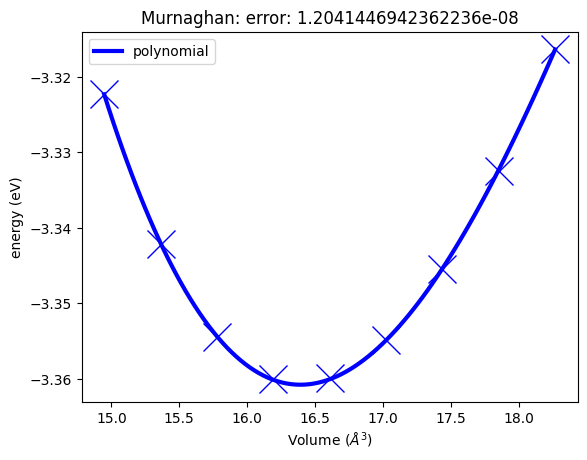

<Axes: title={'center': 'Murnaghan: error: 1.2041446942362236e-08'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [52]:
murn_job.plot()

In [53]:
murn_job["output/equilibrium_volume"], murn_job["output/equilibrium_bulk_modulus"]

(16.39195145005612, 83.49020281566487)

In [54]:
np.linalg.norm(murn_job["output/structure/cell/cell"][0]) * np.sqrt(2)

4.032399480696727

We now analyze the data using our in-built pyiron tables class

In [55]:
# A filter function that selects only Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished")

# Functions to obtain output from Murnaghan jobs
def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["lammps_ref/input/potential/Name"]

In [56]:
# Creating a pyiron table and processing output
table = pr_murn.create.table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm

table.run()
table.get_dataframe()

The job table_murn was saved and received the ID: 58


Loading and filtering jobs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/3 [00:00<?, ?it/s]

job_id                                 potential         a     eq_vol  \
0      17   2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1  4.050000  16.551269   
1      30  2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1  4.050000  16.606563   
2      40   2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2  4.032399  16.391951   

       eq_bm  
0  89.306010  
1  77.715164  
2  83.490203

## Extra Credits

1. Check the E-V curves for different crystal structures of the same element with Murnaghan jobs (Hint: execute `pr.create.structure.bulk?` in a cell)
2. Calculate the thermal expansion for an element and structure of your liking (Hint: run MD at different temperatures with the argument `pressure=0`)